In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS exclusion curve

In [2]:
cmsData = pd.read_pickle('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/DMsimp_spin-0_Monojet_DF.pcl')
cmsCurve = np.genfromtxt('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/HEPData-ins1894408-v2-csv/Signalstrengthlimits,scalarmediator.csv',
                        skip_header=14,names=True,delimiter=',',skip_footer=60)

### Load Recast Data

In [3]:
recastData = pd.read_pickle('../CMS-EXO-20-004/scanResults_scalar_cms_nocut.pcl')

### Get all model points

In [4]:
models = []
mCols = ['Coupling','Mode','$m_{med}$','$m_{DM}$','$g_{DM}$', '$g_{q}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols,row.tolist()))
    if m not in models:
        models.append(m)
print('%i models loaded' %len(models))

25 models loaded


### Get model parameters

In [5]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': 'Scalar', 'Mode': 'DM+QCDjets', '$m_{med}$': [800.0, 450.0, 100.0, 200.0, 10.0, 300.0, 400.0, 50.0, 500.0, 600.0, 700.0, 350.0], '$m_{DM}$': [1.0, 225.0, 4.0, 6.0, 40.0, 200.0, 45.0, 50.0, 275.0, 20.0, 22.0, 55.0, 150.0, 28.0], '$g_{DM}$': 1.0, '$g_{q}$': 1.0}
Coupling = Scalar
Mode = DM+QCDjets
$g_{DM}$ = 1.0
$g_{q}$ = 1.0


In [6]:
# Remove duplicated data from other datasets
recastData = recastData[recastData['Data-takingperiod'] == 2017]
cmsData = cmsData[cmsData['Data-takingperiod'] == 2017]

### Get all model points with common models to CMS data

In [7]:
keys = list(cmsData[mCols].columns.values)
i1 = recastData.set_index(keys).index
i2 = cmsData.set_index(keys).index
recastData = recastData[i1.isin(i2)]
cmsData = cmsData[i2.isin(i1)]
print(len(recastData),len(cmsData))

25 25


In [8]:
recastData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)  
cmsData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
                ascending=[False,False,True,True,False],ignore_index=True)                

### Add ratio of upper limits for the common points

In [9]:
kfactor = 0.8
recastData['UL ratio'] = (recastData['$\mu^{UL}_{obs}$']/kfactor)/cmsData['$\mu^{UL}_{obs}$']

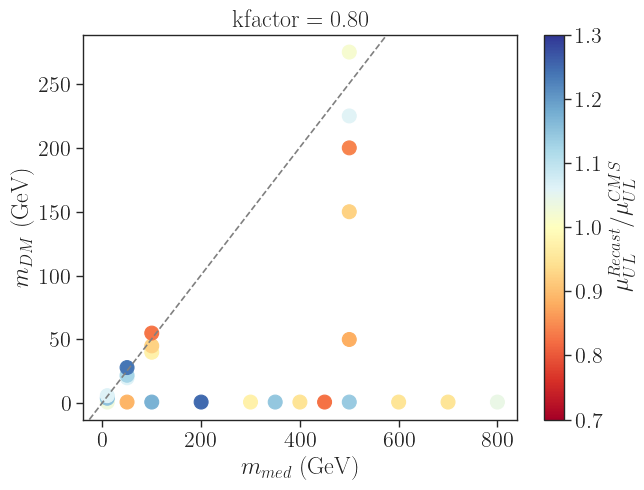

In [10]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=recastData['$m_{med}$'],y=recastData['$m_{DM}$'],vmin=0.7,vmax=1.3,
            c=recastData['UL ratio'],cmap=plt.cm.get_cmap('RdYlBu'),s=100)
cbar = plt.colorbar(label=r'$\mu^{Recast}_{UL}/\mu^{CMS}_{UL}$')
plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

# cbar.set_ticks([0.5,0.75,0.9,1.0,1.1,1.25,1.5])

plt.xlabel(r'$m_{med}$ (GeV)')
plt.ylabel(r'$m_{DM}$ (GeV)')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
# plt.yscale('log')
plt.title('kfactor = %1.2f' %kfactor)
plt.show()

### Get all model points with mDM = 1 GeV

In [11]:
recastData = recastData[(recastData['$m_{DM}$'] == 1.0)]
cmsData = cmsData[(cmsData['$m_{DM}$'] == 1.0)]

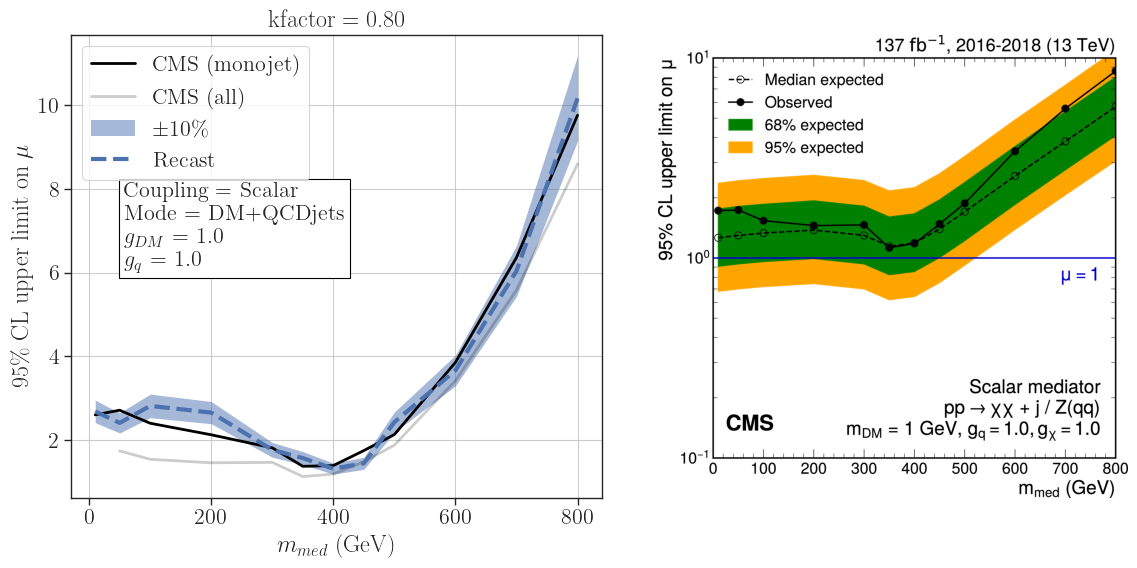

In [12]:
fig,ax = plt.subplots(figsize=(12,6),ncols=2,nrows=1)
ax[0].plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax[0].plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
         linewidth=2,color='black',alpha=0.2)

ax[0].fill_between(recastData['$m_{med}$'],1.1*recastData['$\mu^{UL}_{obs}$']/kfactor,
                 0.9*recastData['$\mu^{UL}_{obs}$']/kfactor,
                alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax[0].plot(recastData['$m_{med}$'],recastData['$\mu^{UL}_{obs}$']/kfactor,
         linestyle='--',label='Recast',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax[0].set_xlabel(r'$m_{med}$ (GeV)')
ax[0].set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
ax[0].set_title('kfactor = %1.2f' %kfactor)
ax[0].text(0.1,0.5,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax[0].transAxes)
ax[0].legend()
ax[0].grid()

cmsPlot = plt.imread('../CMS-EXO-20-004/AuxInfo/CMS-EXO-20-004-data/CMS-EXO-20-004_Figure_009-a.png')
ax[1].imshow(cmsPlot)
ax[1].axis('off')

plt.tight_layout()
plt.show()

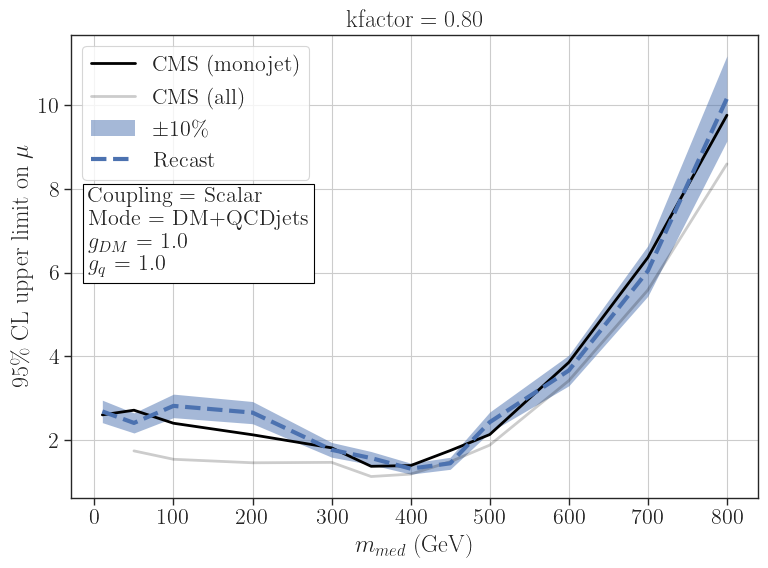

In [13]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(cmsData['$m_{med}$'],cmsData['$\mu^{UL}_{obs}$'],label='CMS (monojet)',linewidth=2,color='black')

ax.plot(cmsCurve['m_med_GeV'],cmsCurve['Signal_strength_limit'],label='CMS (all)',
         linewidth=2,color='black',alpha=0.2)

ax.fill_between(recastData['$m_{med}$'],1.1*recastData['$\mu^{UL}_{obs}$']/kfactor,
                 0.9*recastData['$\mu^{UL}_{obs}$']/kfactor,
                alpha=0.5,linewidth=0,label=r'$\pm 10$\%' )
    
ax.plot(recastData['$m_{med}$'],recastData['$\mu^{UL}_{obs}$']/kfactor,
         linestyle='--',label='Recast',linewidth=3,markersize=7)
    

# plt.hlines(y=1.0,xmin=modelData['$m_{med}$'].min(),xmax=modelData['$m_{med}$'].max(),color='blue')
ax.set_xlabel(r'$m_{med}$ (GeV)')
ax.set_ylabel(r'95\% CL upper limit on $\mu$')
# plt.ylim(-10,1000)
# plt.xlim(0,3000)
ax.set_title('kfactor = %1.2f' %kfactor)
ax.text(0.025,0.49,textstr,fontsize=16,bbox=dict(facecolor='white', edgecolor='black'),
         transform = ax.transAxes)
ax.legend()
ax.grid()

plt.savefig('cms_exo_20_004_scalar.png')
plt.tight_layout()
plt.show()

In [14]:
cutflowRecast = recastData[['$m_{DM}$', '$m_{med}$', 'Fullsample', 'Triggeremulation', '$p_{T}^{miss}>250$GeV', 
                            'Electronveto', 'Muonveto', 'Tauveto', 'Bjetveto', 'Photonveto', '$\\Delta \\phi (jet,p_{T}^{miss})>0.5$ rad',
                            'LeadingAK4jet$p_{T}>100$GeV', 'LeadingAK4jet$\\eta<2.4$', 'HCALmitigation(jets)', 
                            'HCALmitigation($\\phi^{miss}$)']]
cutflowCMS = cmsData[['$m_{DM}$', '$m_{med}$', 'Fullsample', 'Triggeremulation', '$p_{T}^{miss}>250$GeV', 
                      '$p_{T}^{miss}$qualityfilters', 'Electronveto', 'Muonveto', 'Tauveto', 'Bjetveto', 
                      'Photonveto', '$\\Delta \\phi (jet,p_{T}^{miss})>0.5$ rad', '$\\Delta p_{T}^{miss}$ (PF-Cal)$<0.5$ rad', 'LeadingAK4jet$p_{T}>100$GeV', 
                      'LeadingAK4jet$\\eta<2.4$', 'LeadingAK4jetenergyfractions', 'Mono-Voverlapremoval', 
                      'HCALmitigation(jets)', 'HCALmitigation($\\phi^{miss}$)', 
                      '$\\Delta \\phi (\\mathrm{PF}_\\mathrm{Charged})<2.0$ rad']]

In [19]:
cutflowRecast.T

,0,3,7,11,12,13,14,15,16,22,23,24
$m_{DM}$,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
$m_{med}$,10.000000,50.000000,100.000000,200.000000,300.000000,350.000000,400.000000,450.000000,500.000000,600.000000,700.000000,800.000000
Fullsample,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Triggeremulation,0.625014,0.649404,0.678682,0.743491,0.767006,0.775998,0.768208,0.793530,0.799717,0.813238,0.839564,0.845405
$p_{T}^{miss}>250$GeV,0.065148,0.070104,0.086683,0.125751,0.177129,0.185620,0.202042,0.243339,0.255614,0.291275,0.337635,0.353713
Electronveto,0.065148,0.070093,0.086683,0.125749,0.177094,0.185590,0.202042,0.243320,0.255610,0.291275,0.337635,0.353713
Muonveto,0.065148,0.070085,0.086683,0.125749,0.177070,0.185572,0.202042,0.243311,0.255604,0.291271,0.337635,0.353710
Tauveto,0.063777,0.068310,0.084317,0.122412,0.172159,0.180217,0.195867,0.234737,0.247943,0.282749,0.327418,0.344129
Bjetveto,0.055393,0.060123,0.073356,0.107098,0.151034,0.154238,0.170523,0.202352,0.206921,0.240135,0.280320,0.289479
Photonveto,0.055066,0.059728,0.072979,0.106549,0.150212,0.153327,0.169229,0.200963,0.205574,0.238562,0.279033,0.287922


In [20]:
cutflowCMS.T

,0,3,7,11,12,13,14,15,16,22,23,24
$m_{DM}$,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
$m_{med}$,10.000000,50.000000,100.000000,200.00000,300.00000,350.00000,400.00000,450.00000,500.00000,600.00000,700.00000,800.00000
Fullsample,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
Triggeremulation,0.426840,0.446330,0.485790,0.55795,0.60275,0.61437,0.62905,0.64521,0.66163,0.68639,0.70679,0.72050
$p_{T}^{miss}>250$GeV,0.072720,0.080058,0.097048,0.14100,0.18360,0.19832,0.21574,0.23776,0.26057,0.29708,0.33072,0.35461
$p_{T}^{miss}$qualityfilters,0.072632,0.079977,0.096960,0.14082,0.18334,0.19806,0.21544,0.23740,0.26016,0.29657,0.33016,0.35391
Electronveto,0.072490,0.079838,0.096811,0.14054,0.18299,0.19755,0.21494,0.23677,0.25943,0.29575,0.32924,0.35285
Muonveto,0.072323,0.079631,0.096496,0.14013,0.18243,0.19696,0.21430,0.23611,0.25860,0.29489,0.32827,0.35182
Tauveto,0.070680,0.077731,0.094319,0.13692,0.17815,0.19249,0.20904,0.23047,0.25242,0.28790,0.32039,0.34347
Bjetveto,0.070680,0.077731,0.094319,0.13692,0.17815,0.19249,0.20904,0.23047,0.25242,0.28790,0.32039,0.34347


In [15]:
modelFilter = {'$m_{med}$' : 800.0, '$m_{DM}$' : 1.0}

In [16]:
cutflow = pd.concat((cutflowCMS,cutflowRecast))
cutflow = cutflow.loc[(cutflow[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]

In [17]:
relDiff = {}
for c in cutflow.columns:
    xList = cutflow[c].tolist()
    if all(isinstance(x,float) for x in xList):
        if xList[1]:
            relDiff.update({c : [np.abs(xList[0] - xList[1])/xList[0]]})
        else:
            relDiff.update({c : [np.nan]})
diff = pd.DataFrame.from_dict(relDiff)
diff.T

,0
$m_{DM}$,0.000000
$m_{med}$,0.000000
Fullsample,0.000000
Triggeremulation,0.173358
$p_{T}^{miss}>250$GeV,0.002531
$p_{T}^{miss}$qualityfilters,NaN
Electronveto,0.002445
Muonveto,0.005371
Tauveto,0.001920
Bjetveto,0.157192
